<h1>Sieci neuronowe - ćwiczenie 7</h1>

In [18]:
!pip install tensorflow

In [19]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

import torch
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryF1Score, BinaryRecall


<h2>Załadowanie i analiza danych</h2>

In [20]:
data = keras.datasets.imdb.load_data(
    path="imdb.npz",
    num_words=None,
    skip_top=0,
    maxlen=None,
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3
)

In [21]:
train_data = pd.DataFrame(data[0][0], columns=["review"])
train_data["label"] = data[0][1]
test_data = pd.DataFrame(data[1][0], columns=["review"])
test_data["label"] = data[1][1]

# Get 40% of data
train_data = train_data.sample(frac=0.4)
test_data = test_data.sample(frac=0.4)

In [22]:
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

print(train_data.head())
print(test_data.head())


                                              review  label
0  [1, 4, 487, 7, 4, 11834, 5, 4, 2594, 120, 4511...      0
1  [1, 13, 482, 48, 25, 26, 83, 4, 920, 924, 5, 1...      0
2  [1, 13, 219, 12, 13, 1041, 19, 90, 1245, 21, 1...      0
3  [1, 14, 468, 8, 30, 6, 52, 20, 13, 197, 12, 62...      0
4  [1, 13, 633, 358, 6151, 11835, 402, 102, 41, 1...      0
                                              review  label
0  [1, 17, 210, 1820, 9, 389, 17, 1016, 1983, 130...      1
1  [1, 15641, 154, 108, 15, 25, 197, 71, 856, 218...      0
2  [1, 1400, 377, 54, 4314, 6108, 16, 530, 51, 6,...      0
3  [1, 1276, 13, 2904, 4, 7711, 11, 35, 576, 2514...      1
4  [1, 14, 9, 1018, 801, 18, 4, 920, 924, 1308, 3...      0


In [23]:
print(train_data["label"].value_counts()) # Get balance of train labels
print(test_data["label"].value_counts()) # Get balance of test labels

label
1    5003
0    4997
Name: count, dtype: int64
label
1    5017
0    4983
Name: count, dtype: int64


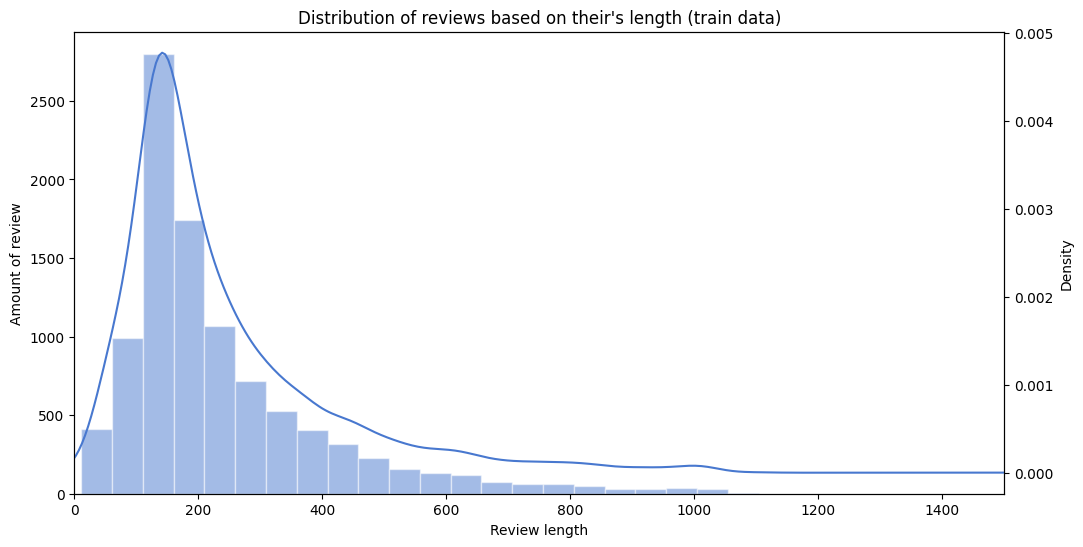

In [24]:
plt.style.use("seaborn-v0_8-muted")

train_data["review_length"] = train_data["review"].apply(len)

fig, ax = plt.subplots(figsize=(12,6))
train_data["review_length"].plot.hist(ax=ax, alpha=0.5, bins=50, edgecolor="white")
ax2 = ax.twinx()
train_data["review_length"].plot.kde(ax=ax2)
ax.set_xlim(0, 1500)
ax.set_xlabel("Review length")
ax.set_ylabel("Amount of review")
ax.set_title("Distribution of reviews based on their's length (train data)")
plt.show()


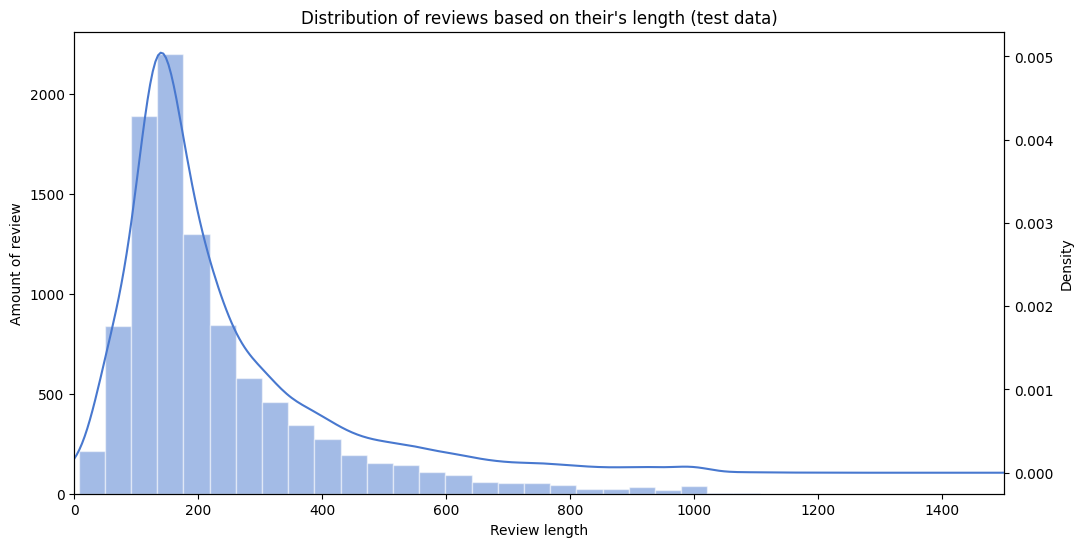

In [25]:

test_data["review_length"] = test_data["review"].apply(len)

fig, ax = plt.subplots(figsize=(12,6))
test_data["review_length"].plot.hist(ax=ax, alpha=0.5, bins=50, edgecolor="white")
ax2 = ax.twinx()
test_data["review_length"].plot.kde(ax=ax2)
ax.set_xlim(0, 1500)
ax.set_xlabel("Review length")
ax.set_ylabel("Amount of review")
ax.set_title("Distribution of reviews based on their's length (test data)")
plt.show()

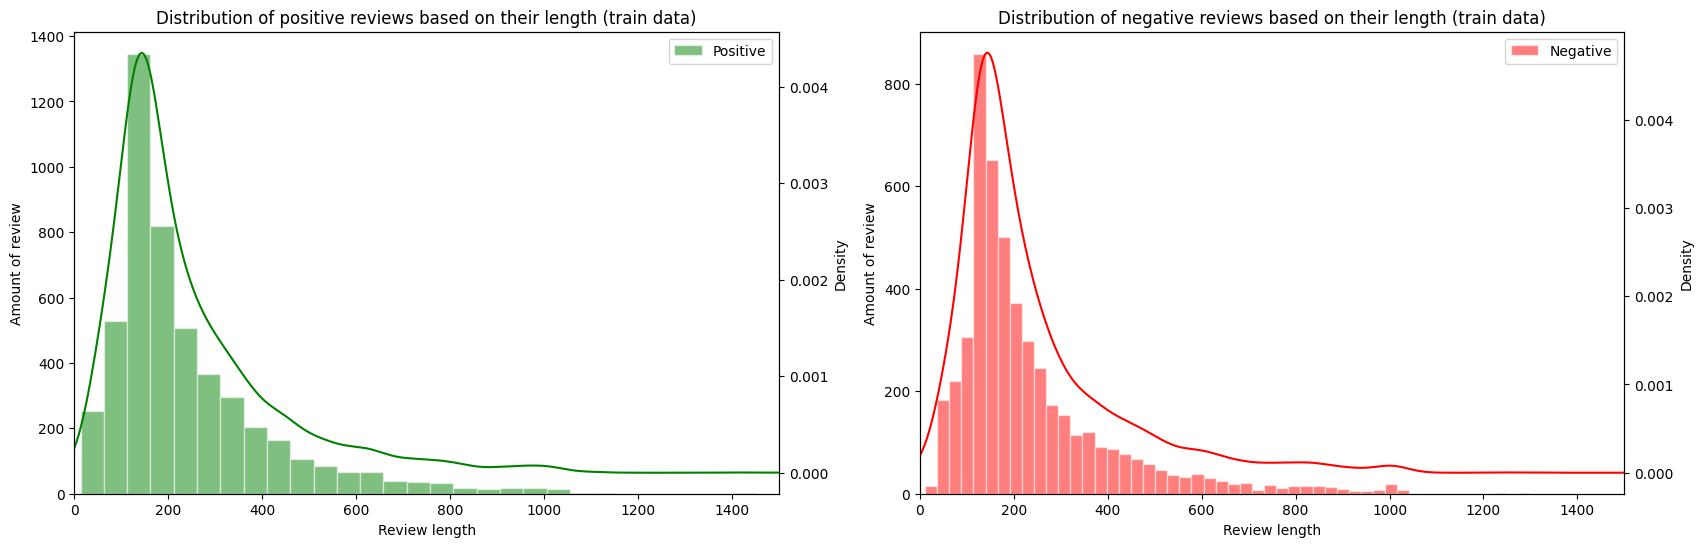

In [26]:
positive_reviews = train_data[train_data["label"] == 1]
negative_reviews = train_data[train_data["label"] == 0]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

positive_reviews["review_length"].plot.hist(ax=ax1, alpha=0.5, bins=50, edgecolor="white", label="Positive", color="green")
ax1_twinx = ax1.twinx()
positive_reviews["review_length"].plot.kde(ax=ax1_twinx, color="green")

negative_reviews["review_length"].plot.hist(ax=ax2, alpha=0.5, bins=50, edgecolor="white", label="Negative", color="red")
ax2_twinx = ax2.twinx()
negative_reviews["review_length"].plot.kde(ax=ax2_twinx, color="red")

ax1.set_xlim(0, 1500)
ax1.set_xlabel("Review length")
ax1.set_ylabel("Amount of review")
ax1.set_title("Distribution of positive reviews based on their length (train data)")
ax1.legend()

ax2.set_xlim(0, 1500)
ax2.set_xlabel("Review length")
ax2.set_ylabel("Amount of review")
ax2.set_title("Distribution of negative reviews based on their length (train data)")
ax2.legend()

plt.show()

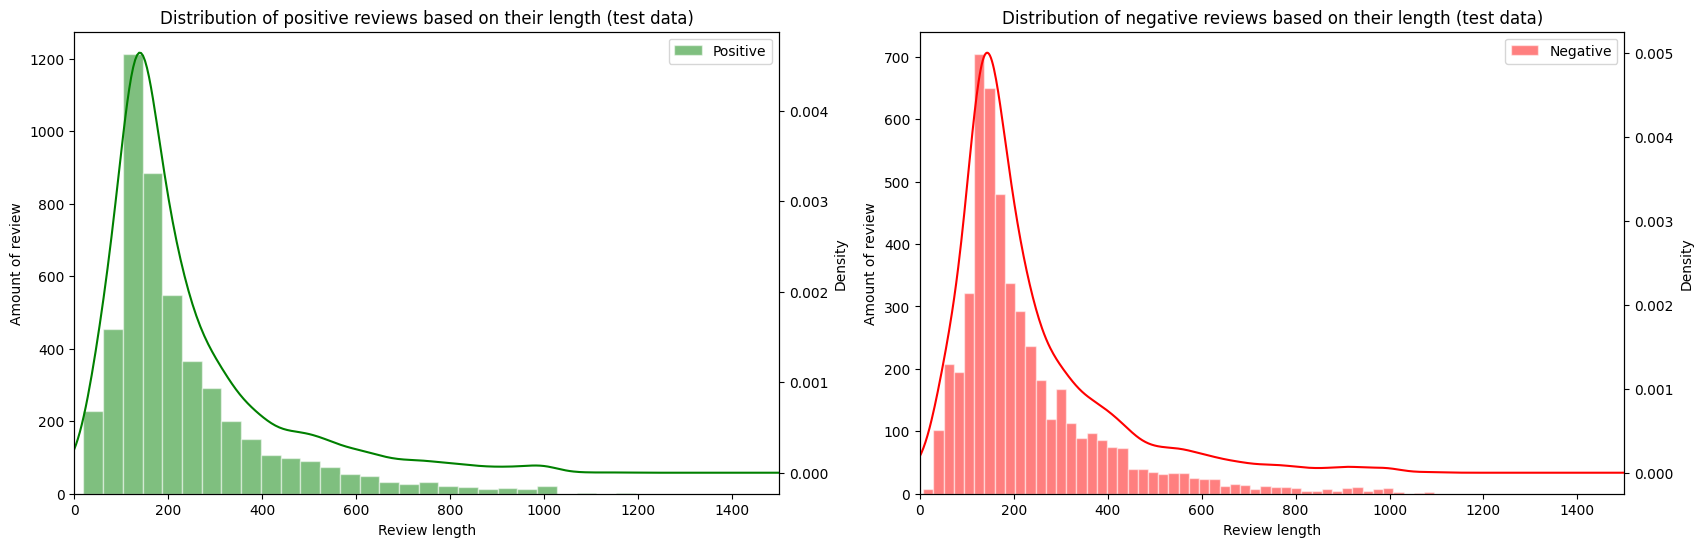

In [27]:
positive_reviews = test_data[test_data["label"] == 1]
negative_reviews = test_data[test_data["label"] == 0]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

positive_reviews["review_length"].plot.hist(ax=ax1, alpha=0.5, bins=50, edgecolor="white", label="Positive", color="green")
ax1_twinx = ax1.twinx()
positive_reviews["review_length"].plot.kde(ax=ax1_twinx, color="green")

negative_reviews["review_length"].plot.hist(ax=ax2, alpha=0.5, bins=50, edgecolor="white", label="Negative", color="red")
ax2_twinx = ax2.twinx()
negative_reviews["review_length"].plot.kde(ax=ax2_twinx, color="red")

ax1.set_xlim(0, 1500)
ax1.set_xlabel("Review length")
ax1.set_ylabel("Amount of review")
ax1.set_title("Distribution of positive reviews based on their length (test data)")
ax1.legend()

ax2.set_xlim(0, 1500)
ax2.set_xlabel("Review length")
ax2.set_ylabel("Amount of review")
ax2.set_title("Distribution of negative reviews based on their length (test data)")
ax2.legend()

plt.show()

<h2>Model sieci</h2>

In [28]:
class RecursiveNetwork(torch.nn.Module):
    def __init__(self, hidden_layers: int, hidden_layers_size: int, input_size: int, output_size: int, network_type: str, vocabulary_size: int, batch_size: int):
        super(RecursiveNetwork, self).__init__()

        self.network_type = network_type
        self.hidden_layers_size = hidden_layers_size
        self.hidden_layers = hidden_layers
        self.batch_size = batch_size

        self.embedding = torch.nn.Embedding(vocabulary_size, input_size)

        match network_type:
            case "RNN":
                self.recursive_layer = torch.nn.RNN(input_size, hidden_layers_size, hidden_layers, batch_first=True)
            case "LSTM":
                self.recursive_layer = torch.nn.LSTM(input_size, hidden_layers_size, hidden_layers, batch_first=True)
            case _:
                raise ValueError("Unknown network type")
        self.output_layer = torch.nn.Linear(hidden_layers_size, output_size)
        torch.nn.init.normal_(self.output_layer.weight)
        torch.nn.init.normal_(self.output_layer.bias)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, inputs):
       match self.network_type:
            case "RNN":
                hidden = torch.zeros(self.hidden_layers, self.batch_size, self.hidden_layers_size)
            case "LSTM":
                hidden = torch.zeros(self.hidden_layers, self.batch_size, self.hidden_layers_size), torch.zeros(self.hidden_layers, self.batch_size, self.hidden_layers_size)
            case _:
                raise ValueError("Unknown network type")
       
       x = self.embedding(inputs)
       output, hidden = self.recursive_layer(x, hidden)
       output = output[:, -1, :]
       output = self.output_layer(output)
       output = self.sigmoid(output)

       return output, hidden



In [29]:
def train_model(model: torch.nn.Module, train_set: torch.Tensor, test_set: torch.Tensor, batch_size: int, optimizer, loss, max_iter: int, learning_rate: float, verb=False):
    
    optimizer = optimizer(model.parameters(), lr = learning_rate) 

    losses = []
    losses_test = []

    accuracy = []
    precision = []
    f_score = []
    recalls = []

    if batch_size > len(train_set):
        batch_size = len(train_set)

    data_loader_train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    data_loader_test = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

    metric_accuracy = BinaryAccuracy()
    metric_precision = BinaryPrecision()
    metric_f_score = BinaryF1Score()
    metric_recall = BinaryRecall()

    for index in range(max_iter): #learn for max_iter  
        curr_train_loss = 0   
        curr_test_loss = 0
        metric_accuracy.reset()
        metric_precision.reset()
        metric_f_score.reset()
        metric_recall.reset()
        
        # for each batch perform learning
        for x_train_batch, y_train_batch in data_loader_train:
            optimizer.zero_grad()
            y_pred, train_hidden_pred = model(x_train_batch)
            loss_value = loss(y_pred.squeeze().float(), y_train_batch.float())
            loss_value.backward()
            optimizer.step()
            curr_train_loss += loss_value.item()
                
        losses.append(curr_train_loss / len(data_loader_train))

        with torch.no_grad():
            model.eval()
            for x_test_batch, y_test_batch in data_loader_test:
                test_pred, test_hidden_pred = model(x_test_batch)
                loss_test_value = loss(test_pred.squeeze().float(), y_test_batch.float())
                curr_test_loss += loss_test_value.item()

                #calculate scores for each batch of iteration
                metric_accuracy.update(test_pred.squeeze(), y_test_batch)
                metric_precision.update(test_pred.squeeze(), y_test_batch)
                metric_f_score.update(test_pred.squeeze(), y_test_batch)
                metric_recall.update(test_pred.squeeze(), y_test_batch)

            losses_test.append(curr_test_loss / len(data_loader_test))    
            accuracy.append(metric_accuracy.compute())
            precision.append(metric_precision.compute())
            f_score.append(metric_f_score.compute())
            recalls.append(metric_recall.compute())

        if verb and index % 10 == 0:
            print("---------------------------------------------- Interation " + str(index))
            print("Train loss on " + str(index) + " iteration: ", losses[index])
            print("Test loss on " + str(index) + " iteration: ", losses_test[index])
            print("Accuracy on " + str(index) + " iteration: ", accuracy[index])
            print("Precision on " + str(index) + " iteration: ", precision[index])
            print("Recall on " + str(index) + " iteration: ", recalls[index])
            print("Fscore on " + str(index) + " iteration: ", f_score[index])
            print("----------------------------------------------\n")

    print("Result of learning process for " + str(max_iter) + " iterations")
    print("--------------------------------------------------------\n")
    print("Train loss: ", losses[-1])
    print("Test loss: ", losses_test[-1])
    print("----------------------------------------------\n")
    print("Scores")
    print("Accuracy: ", accuracy[-1])
    print("Precision: ", precision[-1])
    print("F_score: ", f_score[-1])
    print("Recall: ", recalls[-1])    
    print("")
    return losses, losses_test, accuracy, precision, f_score, recalls

In [30]:
def plot_learning(losses: list, losses_test: list, title: str, axs = None):
    if axs == None:
        plt.plot(np.arange(len(losses)), losses, label="Train Loss")
        plt.plot(np.arange(len(losses)), losses_test, label="Test loss")
        plt.title(title)
        plt.legend()
        plt.show()
    else:
        axs.plot(np.arange(len(losses)), losses, label="Train Loss")
        axs.plot(np.arange(len(losses)), losses_test, label="Test loss")
        axs.set_title(title)
        axs.legend()

<h2>Eksperymenty</h2>

In [31]:
optimizer = torch.optim.Adam
loss = torch.nn.BCELoss()
max_iter = 10
verbose = False
learning_rate = 0.001
batch_size = 500

#1 Typ wybranej warstwy rekurencyjnej (RNN vs. LSTM)
rnn_type = "RNN"
lstm_type = "LSTM"

#2 Wymiar warstwy rekurencyjnej
hidden_layers_2 = 2
hidden_layers_size_20 = 20
hidden_layers_size_40 = 40
hidden_layers_size_60 = 60

#3 Wpływ przycinania sekwencji do niepełnej długości
pad_size_20 = 20
pad_size_50 = 50
pad_size_100 = 100
pad_size_180 = 180
pad_size_250 = 250

In [49]:
def find_max_item(data: torch.utils.data.TensorDataset) -> int:
    return max(review.max().item() for review, _ in data)

def get_vocabulary_size(train_data: torch.utils.data.TensorDataset, test_data: torch.utils.data.TensorDataset) -> int:
    return max(find_max_item(train_data), find_max_item(test_data)) + 1

In [33]:
import math
# options [0] -> network_type, [1] -> train_data, [2] -> test_data, [3] -> hidden_layers, [4] -> hidden_layers_size, [5] -> pad_size
def run_models(options: list, options_title: list):
    fig, axs = plt.subplots(math.ceil(len(options) / 2), 2, figsize=(20, 20))
    if math.ceil(len(options) / 2) == 1:
        axs = [axs]  # Convert the single Axes object to a list
    
    metrics = pd.DataFrame(columns=["Accuracy", "Precision", "F_score", "Recall"])

    for option_index, option in enumerate(options):

        train_set = torch.utils.data.TensorDataset(torch.tensor(keras.utils.pad_sequences(option[1]["review"], maxlen=option[5])), torch.tensor(option[1]["label"]))
        test_set = torch.utils.data.TensorDataset(torch.tensor(keras.utils.pad_sequences(option[2]["review"], maxlen=option[5])), torch.tensor(option[2]["label"]))

        vocabulary_size = get_vocabulary_size(train_set, test_set)
        input_size = option[5]

        print(options_title[option_index])
        model = RecursiveNetwork(option[3], option[4], input_size, 1, option[0], vocabulary_size, batch_size)
        result = train_model(model, train_set, test_set, batch_size, optimizer, loss, max_iter, learning_rate, verb=verbose)
        
        plot_learning(result[0], result[1], options_title[option_index], axs[int(option_index / 2)][option_index % 2])
        new_row = [result[2][-1].item(), result[3][-1].item(),  result[4][-1].item(), result[5][-1].item()]
        metrics.loc[len(metrics)] = new_row
    
    
    print("\nResults: ")
    metrics = metrics.set_axis(options_title, axis='index')
    metrics = metrics.transpose()
    display(metrics)

<h2>#1 Typ sieci oraz #2 Wymiar sieci rekurencyjnej</h2>

Set 40% Adam lr: 0.001 RNN hidden layer size: 20
Result of learning process for 10 iterations
--------------------------------------------------------

Train loss:  0.30411098152399063
Test loss:  0.6103831261396409
----------------------------------------------

Scores
Accuracy:  tensor(0.7193)
Precision:  tensor(0.7240)
F_score:  tensor(0.7179)
Recall:  tensor(0.7118)

Set 40% Adam lr: 0.001 LSTM hidden layer size: 20
Result of learning process for 10 iterations
--------------------------------------------------------

Train loss:  0.07341981492936611
Test loss:  0.6573410928249359
----------------------------------------------

Scores
Accuracy:  tensor(0.7790)
Precision:  tensor(0.7886)
F_score:  tensor(0.7763)
Recall:  tensor(0.7644)

Set 40% Adam lr: 0.001 RNN hidden layer size: 40
Result of learning process for 10 iterations
--------------------------------------------------------

Train loss:  0.26394680216908456
Test loss:  0.6995384514331817
-----------------------------------

,Set 40% Adam lr: 0.001 RNN hidden layer size: 20,Set 40% Adam lr: 0.001 LSTM hidden layer size: 20,Set 40% Adam lr: 0.001 RNN hidden layer size: 40,Set 40% Adam lr: 0.001 LSTM hidden layer size: 40,Set 40% Adam lr: 0.001 RNN hidden layer size: 60,Set 40% Adam lr: 0.001 LSTM hidden layer size: 60
Accuracy,0.719300,0.779000,0.683100,0.798000,0.731000,0.762900
Precision,0.724047,0.788608,0.713001,0.791935,0.752331,0.765663
F_score,0.717861,0.776316,0.661251,0.800985,0.720607,0.762829
Recall,0.711780,0.764401,0.616504,0.810245,0.691449,0.760016


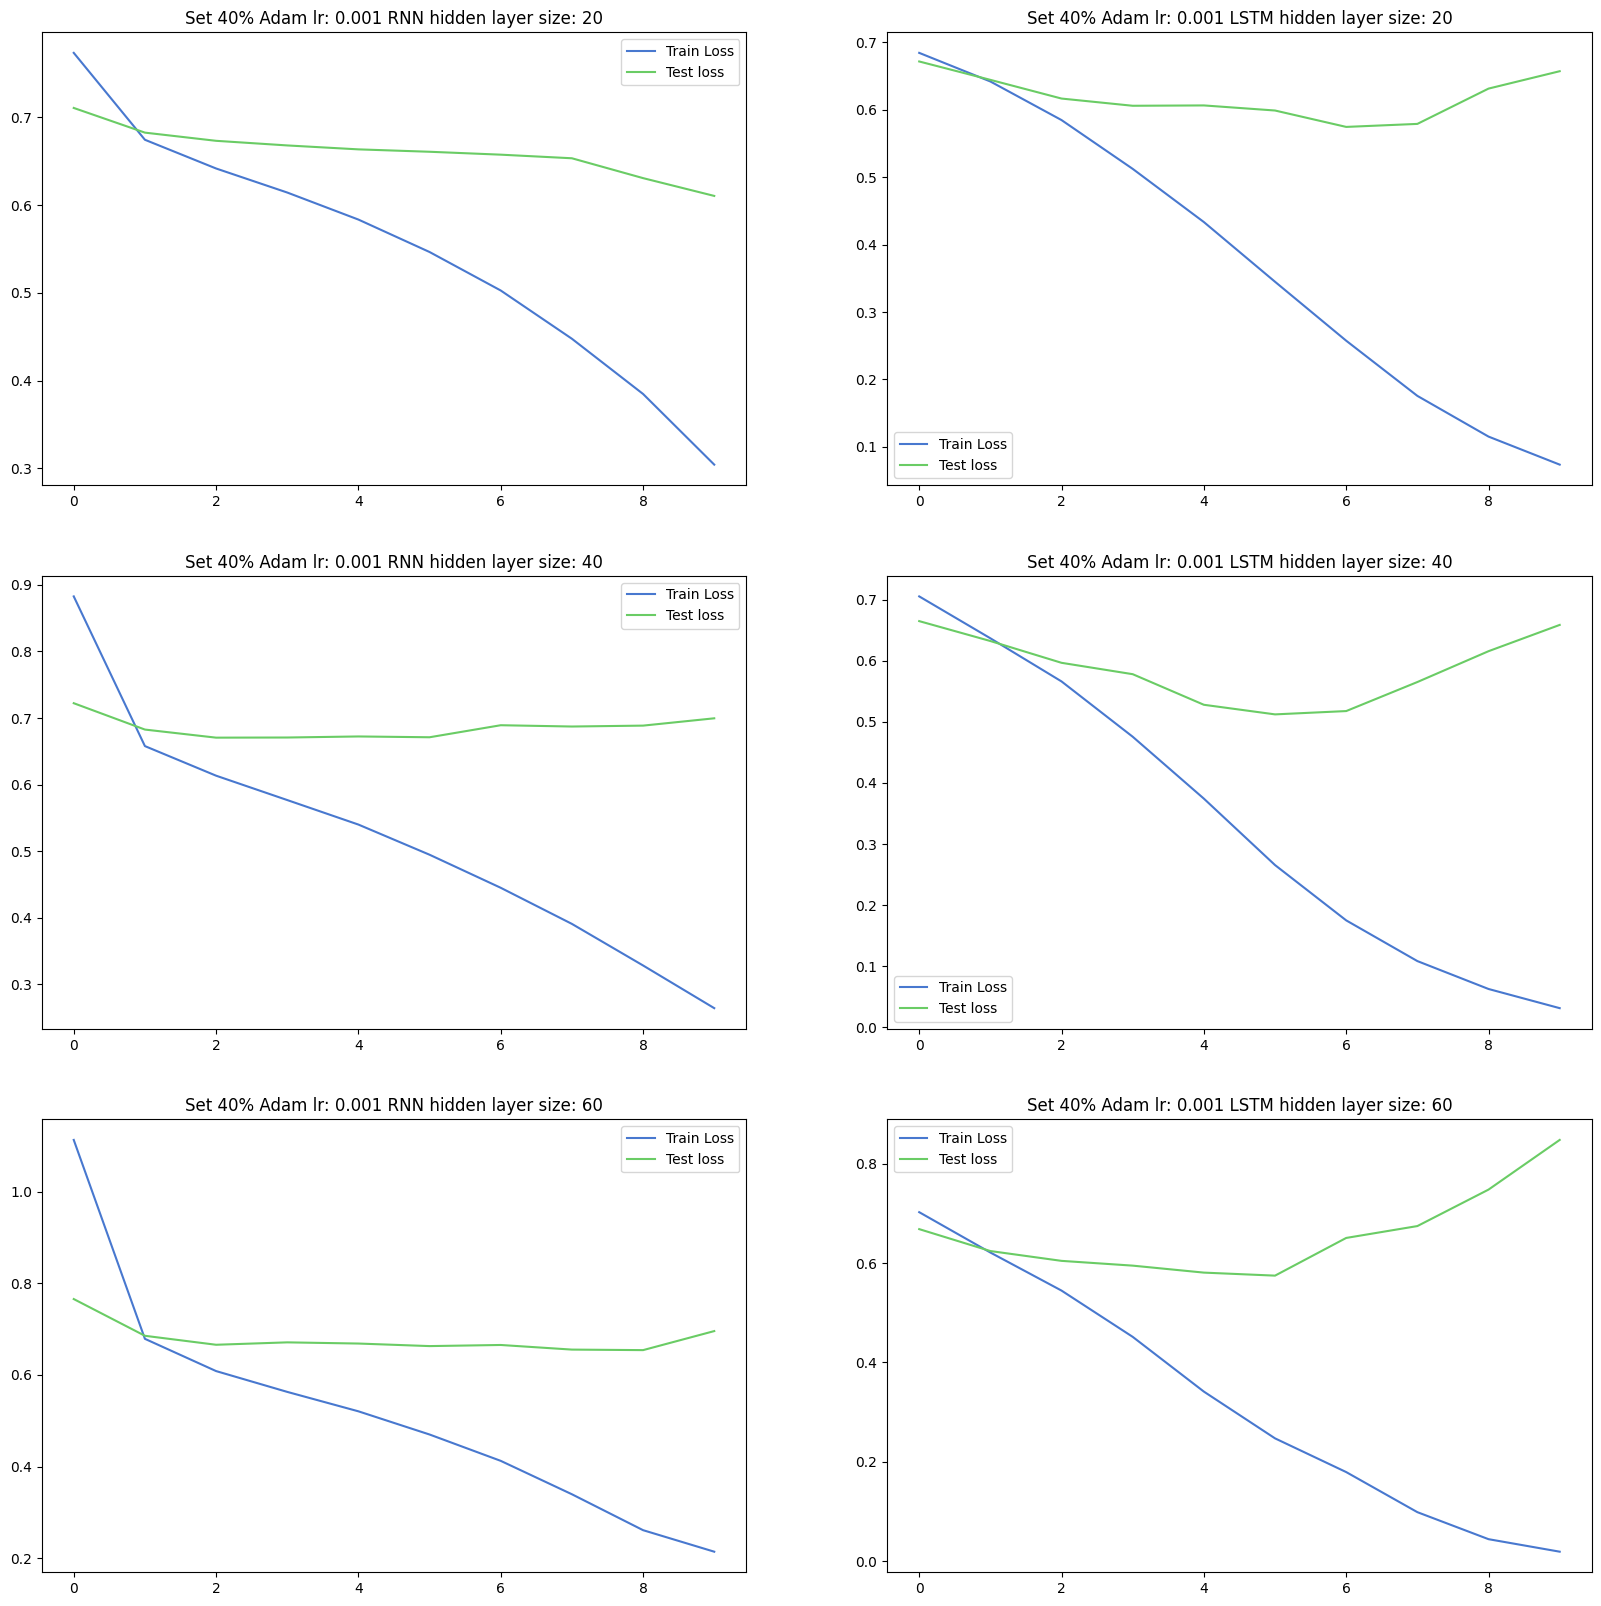

In [34]:
options_neurons_size = [[rnn_type, train_data, test_data, hidden_layers_2, hidden_layers_size_20, pad_size_250], 
                        [lstm_type, train_data, test_data, hidden_layers_2, hidden_layers_size_20, pad_size_250],
                        [rnn_type, train_data, test_data, hidden_layers_2, hidden_layers_size_40, pad_size_250],
                        [lstm_type, train_data, test_data, hidden_layers_2, hidden_layers_size_40, pad_size_250],
                        [rnn_type, train_data, test_data, hidden_layers_2, hidden_layers_size_60, pad_size_250],
                        [lstm_type, train_data, test_data, hidden_layers_2, hidden_layers_size_60, pad_size_250]]

options_neurons_titles = ["Set 40% Adam lr: " + str(learning_rate) + " " + rnn_type + " hidden layer size: " + str(hidden_layers_size_20), 
                          "Set 40% Adam lr: " + str(learning_rate) + " " + lstm_type + " hidden layer size: " + str(hidden_layers_size_20),
                          "Set 40% Adam lr: " + str(learning_rate) + " " + rnn_type + " hidden layer size: " + str(hidden_layers_size_40),
                          "Set 40% Adam lr: " + str(learning_rate) + " " + lstm_type + " hidden layer size: " + str(hidden_layers_size_40),
                          "Set 40% Adam lr: " + str(learning_rate) + " " + rnn_type + " hidden layer size: " + str(hidden_layers_size_60),
                          "Set 40% Adam lr: " + str(learning_rate) + " " + lstm_type + " hidden layer size: " + str(hidden_layers_size_60)]

run_models(options_neurons_size, options_neurons_titles)

<h2>#1 Typ sieci oraz #3 Wpływ przycinania sekwencji do niepełnej długości</h2>

Set 40% Adam lr: 0.001 RNN pad size: 20
Result of learning process for 10 iterations
--------------------------------------------------------

Train loss:  0.6026268631219864
Test loss:  0.6573520183563233
----------------------------------------------

Scores
Accuracy:  tensor(0.6113)
Precision:  tensor(0.6233)
F_score:  tensor(0.5951)
Recall:  tensor(0.5693)

Set 40% Adam lr: 0.001 LSTM pad size: 20
Result of learning process for 10 iterations
--------------------------------------------------------

Train loss:  0.513820169866085
Test loss:  0.6231437683105469
----------------------------------------------

Scores
Accuracy:  tensor(0.6658)
Precision:  tensor(0.6524)
F_score:  tensor(0.6821)
Recall:  tensor(0.7146)

Set 40% Adam lr: 0.001 RNN pad size: 50
Result of learning process for 10 iterations
--------------------------------------------------------

Train loss:  0.5511883109807968
Test loss:  0.6668966740369797
----------------------------------------------

Scores
Accuracy:  

,Set 40% Adam lr: 0.001 RNN pad size: 20,Set 40% Adam lr: 0.001 LSTM pad size: 20,Set 40% Adam lr: 0.001 RNN pad size: 50,Set 40% Adam lr: 0.001 LSTM pad size: 50,Set 40% Adam lr: 0.001 RNN pad size: 100,Set 40% Adam lr: 0.001 LSTM pad size: 100,Set 40% Adam lr: 0.001 RNN pad size: 180,Set 40% Adam lr: 0.001 LSTM pad size: 180,Set 40% Adam lr: 0.001 RNN pad size: 250,Set 40% Adam lr: 0.001 LSTM pad size: 250
Accuracy,0.611300,0.665800,0.616600,0.737200,0.695300,0.796800,0.724600,0.778400,0.718800,0.782100
Precision,0.623309,0.652411,0.606865,0.718333,0.682882,0.783261,0.695187,0.772524,0.739414,0.800000
F_score,0.595062,0.682078,0.636657,0.749428,0.707104,0.802450,0.745330,0.781804,0.707753,0.776444
Recall,0.569264,0.714570,0.669524,0.783337,0.733107,0.822603,0.803269,0.791310,0.678692,0.754236


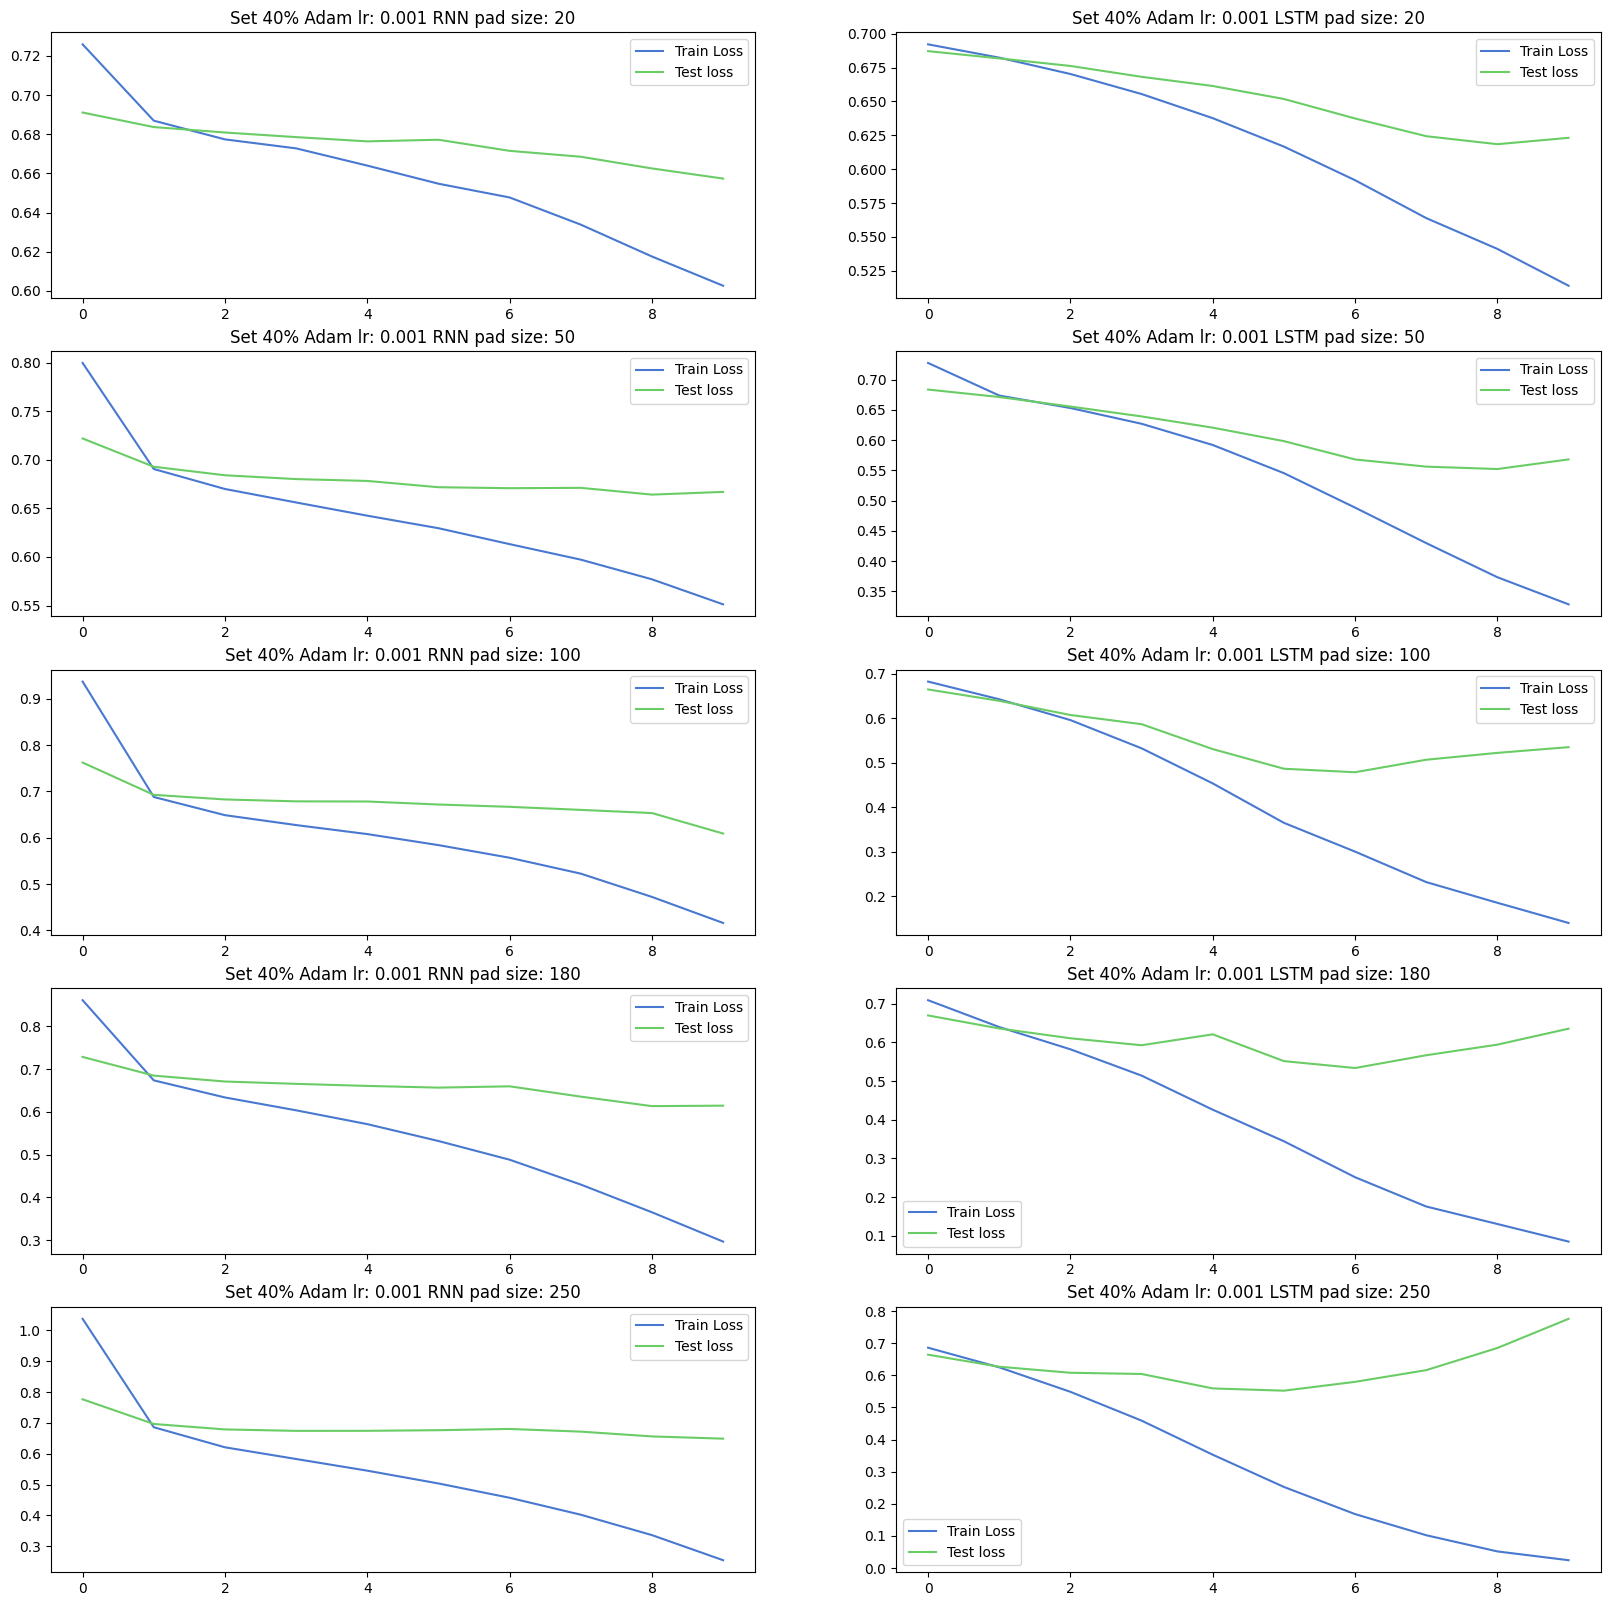

In [35]:
options_neurons_size = [[rnn_type, train_data, test_data, hidden_layers_2, hidden_layers_size_40, pad_size_20], 
                        [lstm_type, train_data, test_data, hidden_layers_2, hidden_layers_size_40, pad_size_20],
                        [rnn_type, train_data, test_data, hidden_layers_2, hidden_layers_size_40, pad_size_50], 
                        [lstm_type, train_data, test_data, hidden_layers_2, hidden_layers_size_40, pad_size_50],
                        [rnn_type, train_data, test_data, hidden_layers_2, hidden_layers_size_40, pad_size_100],
                        [lstm_type, train_data, test_data, hidden_layers_2, hidden_layers_size_40, pad_size_100],
                        [rnn_type, train_data, test_data, hidden_layers_2, hidden_layers_size_40, pad_size_180],
                        [lstm_type, train_data, test_data, hidden_layers_2, hidden_layers_size_40, pad_size_180],
                        [rnn_type, train_data, test_data, hidden_layers_2, hidden_layers_size_40, pad_size_250],
                        [lstm_type, train_data, test_data, hidden_layers_2, hidden_layers_size_40, pad_size_250]]

options_neurons_titles = ["Set 40% Adam lr: " + str(learning_rate) + " " + rnn_type + " pad size: " + str(pad_size_20), 
                          "Set 40% Adam lr: " + str(learning_rate) + " " + lstm_type + " pad size: " + str(pad_size_20),
                          "Set 40% Adam lr: " + str(learning_rate) + " " + rnn_type + " pad size: " + str(pad_size_50), 
                          "Set 40% Adam lr: " + str(learning_rate) + " " + lstm_type + " pad size: " + str(pad_size_50),
                          "Set 40% Adam lr: " + str(learning_rate) + " " + rnn_type + " pad size: " + str(pad_size_100),
                          "Set 40% Adam lr: " + str(learning_rate) + " " + lstm_type + " pad size: " + str(pad_size_100),
                          "Set 40% Adam lr: " + str(learning_rate) + " " + rnn_type + " pad size: " + str(pad_size_180),
                          "Set 40% Adam lr: " + str(learning_rate) + " " + lstm_type + " pad size: " + str(pad_size_180),
                          "Set 40% Adam lr: " + str(learning_rate) + " " + rnn_type + " pad size: " + str(pad_size_250),
                          "Set 40% Adam lr: " + str(learning_rate) + " " + lstm_type + " pad size: " + str(pad_size_250)]

run_models(options_neurons_size, options_neurons_titles)

<p><i>Wykonane przez Szymona Sawczuka nr indeksu 260287</i></p>